# Reading in Low fidelity (elevation and Temperature) and high fidelity data (surface temperature, elevation)

In [1]:
import xarray as xr
import iris
import numpy as np 
import pylab as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import os
import netCDF4 as nc


# In[13]:



### Regional gridded output from a Regional Climate Model (RCM)
hi_t2   = xr.open_dataset('data/hifid_t2m_monthly.nc')
hi_lats = hi_t2['latitude'].values
hi_lons = hi_t2['longitude'].values 

### Global gridded reanalysis (data assimilated) used to update/force the 
### lateral boundaries of the RCM
lo_t2  = xr.open_dataset('data/lofid_t2m_monthly.nc')
lo_u10 = xr.open_dataset('data/lofid_u10_monthly.nc')
lo_v10 = xr.open_dataset('data/lofid_v10_monthly.nc')

### work with numpy arrays
hi_t2_arr  = hi_t2['t2m'].values
lo_t2_arr  = lo_t2['t2m'].values 
lo_u10_arr = lo_u10['u10'].values
lo_v10_arr = lo_v10['v10'].values
time_dim   = lo_t2['time'].values 


##low fidelity lat and lon 
lo_lats = lo_t2['latitude'].values
lo_lons = lo_t2['longitude'].values

# high fidelity elevation data 
hi_elev = xr.open_dataset('data/hifid_hgt.nc')['hgt'].values
print(hi_elev.shape)
lo_t2_arr.shape
test = xr.open_dataset('data/hifid_hgt.nc')
hi_t2_arr.shape[0]*0.5

(93, 87)


234.0

# Read in low fidelity elevation data

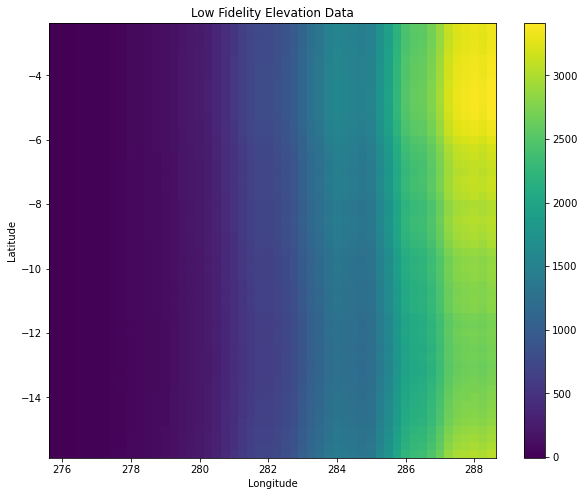

In [2]:
lo_elev_2= xr.open_dataset('low_fidelity_elevation_3.nc')

# mean of x1 along time axis
lo_elev_mean = lo_elev_2['lo_elev'].mean(dim = 'time')


"""plot of low fidelity elevation data"""    

plt.figure(figsize=(10,8))
plt.pcolormesh(lo_lons, lo_lats, lo_elev_mean)
plt.colorbar()
plt.title('Low Fidelity Elevation Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



# Climate downscaling function
 - Input low fidelity wind speed, low fidelity elevation and high resolution elevation 
 
 - output high fidelity windspeed

In [21]:
#def train_temp_model(temp_data, elevation_data, temp_data_lowres):
def climate_downscaling(elev_lowres, velocity_lowres, elev_highres):
    #padding the low resolution data with zeros
    padded_elev_data = np.zeros(elev_highres.shape)
    padded_elev_data[:elev_lowres.shape[0],:elev_lowres.shape[1]] = elev_lowres

    #padding velocity data with zeros
    padded_velocity_data = np.zeros(elev_highres.shape)
    padded_velocity_data[:velocity_lowres.shape[0],:velocity_lowres.shape[1]] = velocity_lowres
    
    # Define the model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(padded_elev_data.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(padded_velocity_data.shape[1]))
    

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(padded_elev_data, padded_velocity_data, epochs=100, batch_size=32, verbose = False) # verbose = 0 showing no training progress

      
    # Predict elevation using the padded low-resolution temperature data
    velocity_pred = model.predict(elev_highres)

    return velocity_pred

# Generate high fidelity U10 and V10 velocity data 

In [31]:
velocity_hires = np.array([]) # initializing the high resolution velocity array

elev_lowres= xr.open_dataset('low_fidelity_elevation_3.nc')
elev_highres = hi_elev.copy() # copying the high fidelity elevation data
# mean of x1 along time axis
elev_lowres_mean = elev_lowres['lo_elev'].mean(dim = 'time') # taking a mean, since elevations doesnt change with time

u10_lowres = xr.open_dataset('data/lofid_u10_monthly.nc')['u10'].values
v10_lowres = xr.open_dataset('data/lofid_v10_monthly.nc')['v10'].values

#for testing for 5 time indeces to check if the code works
num_elements = hi_t2_arr.shape[0]

u10_lowres = u10_lowres[:num_elements,:,:]  # this is to test over a smaller set
v10_lowres = v10_lowres[:num_elements,:,:]  # this is to test over a smaller set

# these for loops are to generate U10 and V10 high fidelity data

for i in range(u10_lowres.shape[0]):
#for i in range(1):
    # downscaling for U10
    pred1 = climate_downscaling(elev_lowres_mean, u10_lowres[i,:,:], elev_highres)
    pred1 = pred1[np.newaxis,:,:] # add a new axis
    
    # downscaling for V10
    pred2 = climate_downscaling(elev_lowres_mean, v10_lowres[i,:,:], elev_highres)
    pred2 = pred2[np.newaxis,:,:] # add a new axis
    
    if i ==0:
        temp1 = pred1.copy()
        temp2 = pred2.copy()
    else:
        temp1 = np.concatenate([temp1,pred1], axis = 0)
        temp2 = np.concatenate([temp2,pred2], axis = 0)
    print(f'value of i is {i} and max val = {u10_lowres.shape[0]}')

U10_highres = temp1
V10_highres = temp2
#print(hi_t2_arr.shape)
#print(lo_t2_arr.shape)
#print(pred.shape)


value of i is 0 and max val = 1


# Save Netcdf file 

In [32]:
def create_netcdf(filename, time, latitude, longitude, data):
    
    filepath = os.path.join(os.getcwd(),filename)
    flag = os.path.exists(filepath)
    
    if flag == True:
        os.remove(filename)
    
    # Open a new NetCDF file
    nc_file = nc.Dataset(filename, "w", format="NETCDF4")

    # Create dimensions
    nc_file.createDimension("time", len(time))
    nc_file.createDimension("latitude", len(latitude))
    nc_file.createDimension("longitude", len(longitude))

    # Create variables
    time_var = nc_file.createVariable("time", "f8", ("time",))
    lat_var = nc_file.createVariable("latitude", "f4", ("latitude",))
    lon_var = nc_file.createVariable("longitude", "f4", ("longitude",))
    data_var = nc_file.createVariable("lo_elev", "f4", ("time", "latitude", "longitude"))

    # Write data to variables
    time_var[:] = time
    lat_var[:] = latitude
    lon_var[:] = longitude
    data_var[:,:,:] = data

    # Add variable attributes
    #time_var.units = "hours since 0001-01-01 00:00:00"
    lat_var.units = "degrees"
    lon_var.units = "degrees"

    # Close the NetCDF file
    nc_file.close()

time = time_dim[:num_elements]
latitude = hi_lats
longitude = hi_lons
#data1 = U10_highres

# print time latitude longitude and data shape
print('time shape: ', time.shape)

print('latitude shape: ', latitude.shape)

print('longitude shape: ', longitude.shape)

print('data shape: ', U10_highres.shape)

create_netcdf("U10m_1.nc", time, latitude, longitude, U10_highres)
create_netcdf("V10m_1.nc", time, latitude, longitude, V10_highres)



time shape:  (1,)
latitude shape:  (93,)
longitude shape:  (87,)
data shape:  (1, 93, 87)


<xarray.Dataset>
Dimensions:    (time: 468, latitude: 54, longitude: 52)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2018-12-31
  * latitude   (latitude) float32 -2.5 -2.75 -3.0 -3.25 ... -15.25 -15.5 -15.75
  * longitude  (longitude) float32 275.8 276.0 276.2 276.5 ... 288.0 288.2 288.5
Data variables:
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Description:  Low Fidelity Climate Model Output

In [34]:
x = hi_t2_arr.shape[0]
x

468